       Re(Z)     Im(Z)  Cycle_Count
0   0.171894  0.006186          1.0
1   0.165188 -0.003868          2.0
2   0.173923 -0.006348          3.0
3   0.119149  0.032906          4.0
4   0.171267  0.010146          5.0
5   0.160277  0.020699          6.0
6   0.166268 -0.004045          7.0
7   0.175343 -0.006520          8.0
8   0.171488  0.005909          9.0
9   0.155384  0.023673         10.0
10  0.170585  0.009437         11.0
11 -0.091016  0.065498         12.0
12  0.172002  0.006016         13.0
13  0.164874 -0.004167         14.0
14  0.178336 -0.006806         15.0
15  0.149533  0.024859         16.0
16  0.169229  0.010149         17.0
17 -0.019212  0.025884         18.0
18  0.163902 -0.004398         19.0
19  0.172261  0.006042         20.0
Total impedance data points extracted: 1956


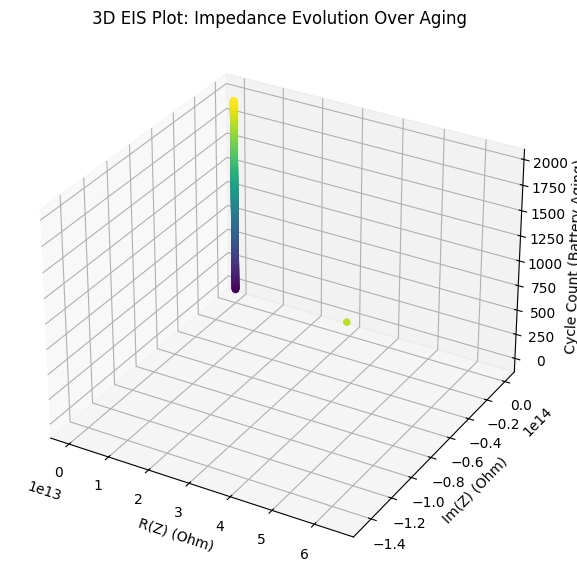

In [ ]:
# 3D Visualization of Battery Impedance Evolution Over Aging

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime

metadata_df = pd.read_csv('../cleaned_dataset/metadata.csv')
impedance_metadata = metadata_df[metadata_df['type'] == 'impedance'][['start_time', 'filename',]]

def parse_start_time(value):
    try:
        if isinstance(value, str):
            value = value.strip('[]').replace(',', '')
            components = [float(x) for x in value.split()]
            if len(components) == 6:
                year, month, day, hour, minute = map(int, components[:5])
                second = int(components[5])
                return datetime(year, month, day, hour, minute, second)
    except Exception as e:
        print(f"Failed to parse start_time: {value}, Error: {e}")
        return pd.NaT

impedance_metadata['start_time'] = impedance_metadata['start_time'].apply(parse_start_time)
impedance_metadata = impedance_metadata.dropna().sort_values(by='start_time').reset_index(drop=True)
impedance_metadata['Cycle_Count'] = impedance_metadata.index + 1

def extract_impedance_data(file_path):
    try:
        df = pd.read_csv(file_path)
        df['Battery_impedance'] = df['Battery_impedance'].astype(str)
        df['Re(Z)'] = df['Battery_impedance'].apply(lambda x: float(complex(x).real) if '(' in x else np.nan)
        df['Im(Z)'] = df['Battery_impedance'].apply(lambda x: float(complex(x).imag) if '(' in x else np.nan)
        return df[['Re(Z)', 'Im(Z)']].mean()
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return pd.Series({'Re(Z)': np.nan, 'Im(Z)': np.nan})

base_path = '../cleaned_dataset/data/'
impedance_data = []
for idx, row in impedance_metadata.iterrows():
    file_path = os.path.join(base_path, row['filename'])
    if os.path.exists(file_path):
        impedance_values = extract_impedance_data(file_path)
        impedance_values['Cycle_Count'] = row['Cycle_Count']
        impedance_data.append(impedance_values)

impedance_df = pd.DataFrame(impedance_data).dropna()
print(impedance_df[['Re(Z)', 'Im(Z)', 'Cycle_Count']].head(20))
print(f"Total impedance data points extracted: {len(impedance_df)}")

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    impedance_df['Re(Z)'],
    impedance_df['Im(Z)'],
    impedance_df['Cycle_Count'],
    c=impedance_df['Cycle_Count'], cmap='viridis'
)
ax.set_xlabel('R(Z) (Ohm)')
ax.set_ylabel('Im(Z) (Ohm)')
ax.set_zlabel('Cycle Count (Battery Aging)')
ax.set_title('3D EIS Plot: Impedance Evolution Over Aging')

plt.show()